##### Understand, in 2D context, torch-interpol and torch-functional affine matrix, grid and warping

#### Import

In [1]:
#Helper functions
import os, sys, json, pathlib, shutil, glob
import pandas as pd
import csv
import SimpleITK as sitk
import nibabel as nib
import random
import math
import numpy as np
from PIL import Image, ImageFont, ImageDraw

import scipy
from scipy.io import loadmat
from scipy import  signal

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interactive,interact, interact_manual, HBox, Layout,VBox
from IPython.display import display, clear_output

import interpol
from interpol.api import affine_grid

from scipy import ndimage

from functools import partial

import torch
import torch.nn.functional as F
from torch.nn import MSELoss
from viu.io import volume
from viu.io.volume import read_volume
from viu.torch.deformation.fields import DVF, set_identity_mapping_cache
from viu.torch.io.deformation import *
from viu.util.body_mask import seg_body

#### Create test image and display

shape: (height, width) : (128, 256) 
center_x 128 center_y 64
patch_w 16 patch_h 16
patch_center_x 192 patch_center_y 32
patch extent height: 24 to 40  width 184 to 200
anImg type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([128, 256])
patch_lower_left_x 184 patch_lower_left_y 40


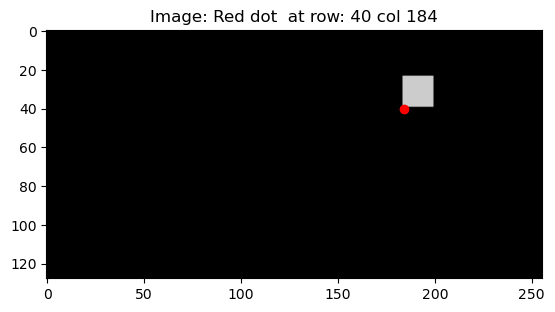

In [2]:
toy_w, toy_h = 256, 128 #6, 4 #20, 5
print(f'shape: (height, width) : {toy_h, toy_w} ')

anImg = torch.ones((toy_h, toy_w))*(-1000.0)
center_x, center_y = toy_w//2, toy_h//2 #center of image
print(f'center_x {center_x} center_y {center_y}')
patch_w, patch_h = 16, 16 #4,4 #toy_w//16, toy_h//16 #toy_w//16, toy_h//16 #patch width height
print(f'patch_w {patch_w} patch_h {patch_h}')
patch_center_x, patch_center_y = center_x + toy_w//4,  center_y - toy_h//4 #patch center
print(f'patch_center_x {patch_center_x} patch_center_y {patch_center_y}')
print(f'patch extent height: {patch_center_y - patch_h//2} to {patch_center_y + patch_h//2}  width {patch_center_x - patch_w//2} to {patch_center_x + patch_w//2}')
anImg[(patch_center_y - patch_h//2) : (patch_center_y + patch_h//2),  (patch_center_x - patch_w//2) : (patch_center_x + patch_w//2)] = 200.0
print(f'anImg type {type(anImg)} dtype {anImg.dtype} shape {anImg.shape}')
reg_cmap='gray'
reg_vmin=-1000
reg_vmax=500

patch_lower_left_x = patch_center_x - patch_w//2
patch_lower_left_y = patch_center_y + patch_h//2
print(f'patch_lower_left_x {patch_lower_left_x} patch_lower_left_y {patch_lower_left_y}')

plt.imshow(anImg, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax) #plt.imshow(anImg, cmap='autumn')
plt.plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
# plt.axis('off')
plt.title(f'Image: Red dot  at row: {patch_lower_left_y} col {patch_lower_left_x}')
plt.show()

Helper function

In [3]:
def displayGrid(grid, width, height, skipFactor, displayString, titleString):
    assert displayString in ['rows', 'cols', 'both'], f'Unacceptable display string: {displayString}.'
    if displayString in ['rows', 'both']:
        skip = height//skipFactor
        for i in range(0, height, skip):
            #i-th skpped-row:  x from 2nd slice, y from 1st slice
            plt.plot(grid[i, :, 1], grid[i, :, 0], color='k') 
        plt.plot(grid[-1, :, 1], grid[-1, :, 0], color='k') # last row
    if displayString in ['cols', 'both']:
        skip = width//skipFactor
        for j in range(0, width, skip):
            #j-th skpped-col: x from 2nd slice, y from 1st slice
            plt.plot(grid[:, j, 1], grid[:, j, 0], color='k')
        plt.plot(grid[:, -1, 1], grid[:, -1, 0], color='k')# last col
    plt.axis('off')
    plt.title(titleString) #plt.title(f'Sampling grid at {theta_deg:.2f} degree')
    plt.show()

#### Get push-type affine matrix

In [4]:
# Helper function to create push type affine matrix :
def getPushRotationMatrixAboutCenterInImageCoord(thetaClockwisePositive_deg, center_row_y, center_col_x):
    """
    thetaClockwisPositive_deg: required rotation of the image. Clockwise is positive here UNLIKE Cartesian system where counter-clockwise is positive
    center_row_y : row index of rotation center
    center_col_x : col index of rotation center
    Return: It returns a push type affine matrix. To be used in pull type warping (e.g., scipy.ndimage.affine_transform),
    use its inverse.

    How is this matrix created?
    See: https://www.researchgate.net/publication/328968274_NumPy_SciPy_Recipes_for_Image_Processing_Affine_Image_Warping
    Following things are kept in mind to  identify the difference from cartesian co-ordinate to image co-ordinate.
    (a) push-type warping;  (b) origin at top left, (c)  pixels accessed  at  (y,x) and (d) clokwise rotation is still positive rotation

    # With above points in mind, code snippets in Listing 1 from above reference are as below:
    # def rotationMatrix(deg):
    #     rad = np.radians(deg)
    #     return np.array([[ np.cos(rad), np.sin(rad)],[-np.sin(rad), np.cos(rad)]])
    # def shearMatrix(sx, sy):
    #     return np.array([[1, sy],[sx, 1]])
    # def scaleMatrix(sx, sy):
    #     return np.array([[sy, 0],[0, sx]])
    # Finally to rotate about center (row:y_c, col: x_c), use T(y_c, x_c) * R * T(-y_c, -x_c)
    # Note the difference from cartesian co-ordinate based rotation matrix 
    # from https://math.stackexchange.com/questions/2093314/rotation-matrix-of-rotation-around-a-point-other-than-the-origin
    """
    rad = np.radians(thetaClockwisePositive_deg)
    rot =           np.array([[ np.cos(rad), np.sin(rad), 0],[-np.sin(rad), np.cos(rad), 0], [0, 0, 1.]], 'float32')
    # print(f'rot: {rot}')
    transToOrigin = np.array([[ 1, 0, -center_row_y],[0, 1, -center_col_x], [0, 0, 1.]], 'float32')
    # print(f'transToOrigin: {transToOrigin}')
    transToCenter = np.array([[ 1, 0,  center_row_y],[0, 1,  center_col_x], [0, 0, 1.]], 'float32')
    # print(f'transToCenter: {transToCenter}')
    pushAffine_np= transToCenter @ rot @ transToOrigin
    return pushAffine_np

Compute location  of bottom left corner after rotation by hand calculation by applying a known rotation about the center of the image

In [5]:
# thetaClockwiseIsPositive_deg = 30.00 #Rotate image  clockwise by 30 degree
thetaClockwiseIsPositive_deg = -10.00 #Rotate image  counter clockwise by 10 degree
pushAffine_np = getPushRotationMatrixAboutCenterInImageCoord(
    thetaClockwisePositive_deg=thetaClockwiseIsPositive_deg, 
    center_row_y=toy_h//2, 
    center_col_x=toy_w//2)
print(f'pushAffine_np {pushAffine_np}')

pushAffine_np [[ 0.9848077  -0.17364818 23.199272  ]
 [ 0.17364818  0.9848077  -9.168869  ]
 [ 0.          0.          1.        ]]


In [6]:
patch_lower_left_x = patch_center_x - patch_w//2
patch_lower_left_y = patch_center_y + patch_h//2
print(f'patch_lower_left_x {patch_lower_left_x} patch_lower_left_y {patch_lower_left_y}')
cornerPointCartesianOriginAtCenterYUpward = np.array([patch_lower_left_x - toy_w//2, -(patch_lower_left_y - toy_h//2) ],'float32')
print(f'cornerPointCartesianOriginAtCenterYUpward {cornerPointCartesianOriginAtCenterYUpward}')
#In cartesian coordinate clockwise rotation is negative
thetaCartesisan= -(thetaClockwiseIsPositive_deg/180.0)*math.pi
rotationMatrix30DegClockwiseCartesianOrigin = np.array([[math.cos(thetaCartesisan), -math.sin(thetaCartesisan)],[math.sin(thetaCartesisan), math.cos(thetaCartesisan)]],'float32')
print(f'rotationMatrix30DegClockwiseCartesianOrigin {rotationMatrix30DegClockwiseCartesianOrigin}')
cornerPointAfter30DegCWCartesianOriginAtCenterYUpward = rotationMatrix30DegClockwiseCartesianOrigin @  cornerPointCartesianOriginAtCenterYUpward
print(f'cornerPointAfter30DegCWCartesianOriginAtCenterYUpward {cornerPointAfter30DegCWCartesianOriginAtCenterYUpward}')
cornerPointAfter30DegCWImageCoord = (cornerPointAfter30DegCWCartesianOriginAtCenterYUpward[0]+toy_w//2, -(cornerPointAfter30DegCWCartesianOriginAtCenterYUpward[1]-toy_h//2))
print(f'cornerPointAfter30DegCWImageCoord {cornerPointAfter30DegCWImageCoord}')

patch_lower_left_x 184 patch_lower_left_y 40
cornerPointCartesianOriginAtCenterYUpward [56. 24.]
rotationMatrix30DegClockwiseCartesianOrigin [[ 0.9848077  -0.17364818]
 [ 0.17364818  0.9848077 ]]
cornerPointAfter30DegCWCartesianOriginAtCenterYUpward [50.981674 33.359684]
cornerPointAfter30DegCWImageCoord (178.98167419433594, 30.640316009521484)


Apply scipy pull-type warping using inverse of push-affine matrix and display expected location of moved bottom left corner of white pach by crosshair

In [7]:
anImg_rot_scipy_pull = np.zeros_like(anImg.numpy())
result=ndimage.affine_transform(
    input=anImg.numpy(), 
    matrix=np.linalg.inv(pushAffine_np), 
    offset=0.0, 
    output_shape=anImg_rot_scipy_pull.shape, 
    output=anImg_rot_scipy_pull, 
    order=3, 
    mode='constant', 
    cval=0.0, 
    prefilter=False)

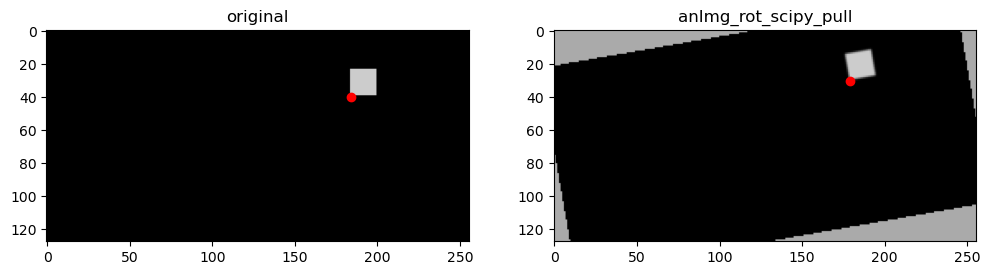

In [8]:
fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_scipy_pull, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
# axArray[1].axhline(y=cornerPointAfter30DegCWImageCoord[1], xmin=0.0, xmax=toy_w, color='r')
# axArray[1].axvline(x=cornerPointAfter30DegCWImageCoord[0], ymin=0.0, ymax=toy_h, color='r')
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_scipy_pull')

Scipy push-type affine matrix creation and pull type rotation seems successful.

Attempt torch-interpol   push type warping

In [9]:
# #Compute destination location  using affine transformation  from 1st principle
# # fwarp(I, I’, T)
# # {
# #   for (y=0; y<I.height; y++)
# #       for (x=0; x<I.width; x++)
# #       {
# #           (x’,y’)=T(x,y);
# #           I’(x’,y’)=I(x,y);
# #       }
# # }
# #Compute destination location  using affine transformation  from 1st principle
# # iwarp(I, I’, T)
# # {
# #   for (y=0; y<I'.height; y++)
# #       for (x=0; x<I'.width; x++)
# #       {
# #           (x,y)=T_inv(x,y); #T_inv = T^(-1)
# #           I’(x’,y’)=I(x,y);
# #       }
# # }

In [10]:
#Compute grid using interpol package
# To create push grid, use  push affine matrix
aRotGrid_push = affine_grid(torch.from_numpy(pushAffine_np),               [toy_h, toy_w])
print(f'aRotGrid_push type {type(aRotGrid_push)} shape {aRotGrid_push.shape} dtype {aRotGrid_push.dtype}')
# To create pull grid, use inverse of push affine matrix
aRotGrid_pull = affine_grid(torch.from_numpy(np.linalg.inv(pushAffine_np)), [toy_h, toy_w])
print(f'aRotGrid_pull type {type(aRotGrid_pull)} shape {aRotGrid_pull.shape} dtype {aRotGrid_pull.dtype}')

aRotGrid_push type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32
aRotGrid_pull type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32


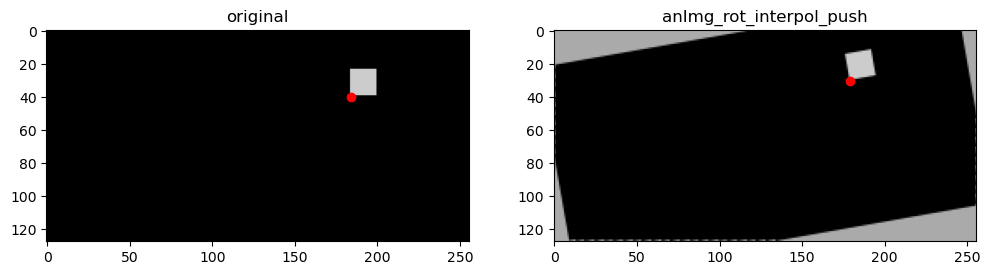

In [11]:
anImg_rot_interpol_push = interpol.grid_push(anImg, aRotGrid_push, interpolation=1, prefilter=False)

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_interpol_push, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_interpol_push')

Attempt torch-interpol   pull  type warping

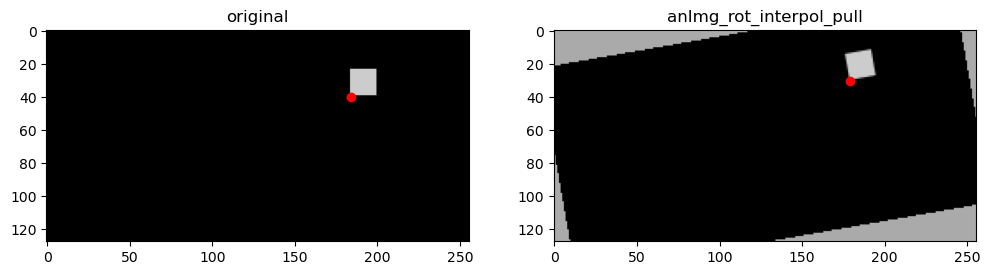

In [12]:
anImg_rot_interpol_pull = interpol.grid_pull(anImg, aRotGrid_pull, interpolation=1, prefilter=False)

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_interpol_pull, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_interpol_pull')

Create pull and push type grid explicitly using  affine matrix multiplication to pixel co-ordinate (y,x) from  identity grid and apply pull and push warping using torch-interpol

In [13]:
identity_grid = torch.stack(torch.meshgrid(*[torch.arange(s).float() for s in [toy_h, toy_w] ],indexing='ij'), -1).numpy().astype('float32')
print(f'identity_grid type {type(identity_grid)} shape {identity_grid.shape} dtype {identity_grid.dtype}')
# print(identity_grid[:,:,0])
# print(identity_grid[:,:,1])
xCoord=toy_w-10
yCoord=toy_h-10
print(f' toy_w {toy_w} toy_h {toy_h}, xCoord {xCoord} yCoord {yCoord} ')
print(f'identity_grid at  COL y:{yCoord}  ROW x:{xCoord}  Slice_0: {identity_grid[yCoord, xCoord, 0]} Slice_1: {identity_grid[yCoord, xCoord, 1]} ')

identity_grid type <class 'numpy.ndarray'> shape (128, 256, 2) dtype float32
 toy_w 256 toy_h 128, xCoord 246 yCoord 118 
identity_grid at  COL y:118  ROW x:246  Slice_0: 118.0 Slice_1: 246.0 


In [14]:
def explicitGridCreation(affineMat_yx_np, identity_grid_yx, toy_h, toy_w, useBatchMatrixMultiplication):
    """
    affineMat_yx_np: affine matrix that is to be multiplied by (row,col) = (y,x)
    co-ordinate to identify destitation / source pixel location
    identity_grid_yx : identity grid containing row indices in 1st slice and column indices in 2nd slice.
    toy_h: height (number of rows) of the identity grid
    toy_w: width (number of columns) of the identity grid
    """
    assert identity_grid_yx.shape == (toy_h, toy_w,2), f'identity_grid shape {identity_grid_yx.shape} not matching ({toy_h}, {toy_w},2)'
    aRotGrid_explicit = np.zeros((toy_h, toy_w, 2))
    if True==useBatchMatrixMultiplication:
        #Demonstrate use of  breaking up the affine matrix between non-translation and translation part and 
        # show use of batch matrix multiplication
        nb_dim = affineMat_yx_np.shape[-1] - 1 #2
        # print(f'nb_dim {nb_dim}')
        # nb_dim 2
        lin = affineMat_yx_np[:nb_dim, :nb_dim] #This is  2x2 or 3x3 rotation matrix
        # print(f'lin shape {lin.shape}')
        # lin shape (2, 2)
        off = affineMat_yx_np[:nb_dim, -1] # This is 2x1 translation matrix
        # print(f'off shape {off.shape}')
        # off shape (2,)
        identity_grid_np = np.stack(np.meshgrid(*[np.arange(s).astype('float32') for s in [toy_h, toy_w] ],indexing='ij'), -1).astype('float32')
        identity_grid_np = identity_grid_np[...,None] #Add extra dimension to support  batch matrix multiplication
        # print(f'identity_grid_np with extra dim for batch matmul: shape {identity_grid_np.shape}')
        # aRotGrid_explicit shape (128, 256, 2, 1)
        part1 = np.matmul(lin, identity_grid_np)  #In  np.matmul 2x2 with  128x256x2x1 will result in  128x256 batch of [2x2]x[2x1] multiplication
        # print(f'part1 shape {part1.shape}')
        # part1 shape (128, 256, 2, 1)
        aRotGrid_explicit = part1.squeeze() + off
        # print(f'aRotGrid_explicit shape {aRotGrid_explicit.shape}')
        # aRotGrid_explicit shape (128, 256, 2)
    else:
        for h in range(toy_h):
            for w in range(toy_w):
                des_yx1 = affineMat_yx_np @ np.array([identity_grid[h,w,0],identity_grid[h,w,1],1.0], 'float32')
                aRotGrid_explicit[h,w,0]=des_yx1[0]
                aRotGrid_explicit[h,w,1]=des_yx1[1]
    return aRotGrid_explicit.astype('float32')

In [15]:
#Compute grid explicitly
# To create push grid, use  push affine matrix
aRotGrid_push_explicit = torch.from_numpy(explicitGridCreation(pushAffine_np, identity_grid, toy_h, toy_w, useBatchMatrixMultiplication=True))
print(f'aRotGrid_push_explicit type {type(aRotGrid_push_explicit)} shape {aRotGrid_push_explicit.shape} dtype {aRotGrid_push_explicit.dtype}')
# To create pull grid, use inverse of push affine matrix
aRotGrid_pull_explicit = torch.from_numpy(explicitGridCreation(np.linalg.inv(pushAffine_np), identity_grid, toy_h, toy_w, useBatchMatrixMultiplication=True)) 
print(f'aRotGrid_pull_explicit type {type(aRotGrid_pull_explicit)} shape {aRotGrid_pull_explicit.shape} dtype {aRotGrid_pull_explicit.dtype}')

aRotGrid_push_explicit type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32
aRotGrid_pull_explicit type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32


Torch interpol push warping using explicitly create push grid

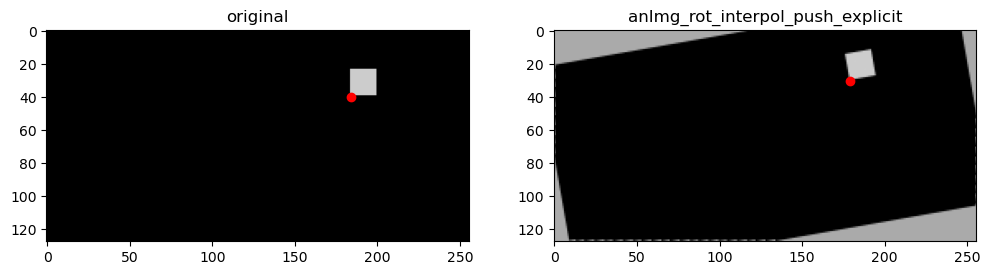

In [16]:
anImg_rot_interpol_push_explicit = interpol.grid_push(anImg, aRotGrid_push_explicit, interpolation=1, prefilter=False)

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_interpol_push_explicit, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_interpol_push_explicit')

Torch interpol pull warping using explicitly create pull grid

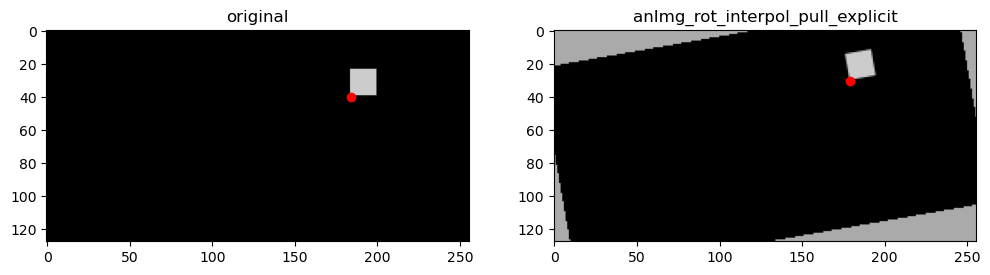

In [17]:
anImg_rot_interpol_pull_explicit = interpol.grid_pull(anImg, aRotGrid_pull_explicit, interpolation=1, prefilter=False)

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_interpol_pull_explicit, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_interpol_pull_explicit')

In [18]:
# displayGrid(grid=aRotGrid_pull, width=toy_w, height=toy_h, skipFactor=4, displayString='both', titleString=f'RotGrid explicit at {theta_deg:.2f} degree')

In [19]:
# print(f'Max diff between aRotGrid and aRotGrid_explicit  {np.max(np.abs(aRotGrid.numpy() - aRotGrid_explicit ))}')
# print(f'Max diff between aRotGrid and aRotGrid_explicit_v2  {np.max(np.abs(aRotGrid.numpy() - aRotGrid_explicit_v2 ))}')
# print(f'Max diff between aRotGrid_explicit and aRotGrid_explicit_v2  {np.max(np.abs(aRotGrid_explicit - aRotGrid_explicit_v2 ))}')

#### Test creation of affine matrix theta, affine_grid and pull type grid_sample using torch.nn.functional

https://discuss.pytorch.org/t/affine-transformation-matrix-paramters-conversion/19522/13

https://discuss.pytorch.org/t/affine-transformation-matrix-paramters-conversion/19522/18

https://stackoverflow.com/questions/61964914/generating-pytorchs-theta-from-affine-transform-matrix

![image info](./normalization.png)

Get PyTorch affine matrix (normalized) theta  from regular affine matrix. 

In [20]:
def normalizeAffineMatImageCoord(unNormalizedAffineMatImageCoord_a2b_np, width_a, height_a, width_b, height_b, returnPyTorchTheta=True):
    """ 
    unNormalizedAffineMatImageCoord_a2b_np : affine matrix (in image co-ordinate) to be multiplied with pixel location (row, col) = (y,x)
    to obtain pixel location in image b,
    width_a, height_a: width and height of image a
    width_b, height_b: width and height of image b
    returnPyTorchTheta: If true, it also returns pyTorch Theta (to be used by F.affine_grid).
    It should be noted that pyTorch Theta is a tensor version of  normalizedAffineMat but to be applied on normalised (x,y) instead of normalised (y,x)
    Therefor 1st two rows of normalizeAffineMat is to be rearranged  before creating theta
    return: 
    1. normalized affine matrix  that is to be multiplied with mormalized pixel location (y,x) (from -1 to +1) of image a to obtain 
    normalized pixel location in image b.
    2. pyTorch Theta to be used by F.affine_grid if returnPyTorchTheta is  true

    """
    T_normalized2Regular_a_yx = np.linalg.inv(np.array([[2./height_a, 0, -1],[0, 2./width_a, -1 ],[0, 0, 1]],'float32'))
    T_regular2Normalized_b_yx =               np.array([[2./height_b, 0, -1],[0, 2./width_b, -1 ],[0, 0, 1]],'float32')
    normalizedAffineMatImageCoord_ab_np = T_regular2Normalized_b_yx @ unNormalizedAffineMatImageCoord_a2b_np @ T_normalized2Regular_a_yx
    if True==returnPyTorchTheta:
        # It seems PyTorch uses 'xy' type meshgrid  while torch-interpol seems to be using 'ij' type meshgrid.
        # Therefore we rearrange 1st two rows of normalizedAffineMatImageCoord_ab_np before creating pyTorch theta 
        # so that it can be applied on (x,y) in stead of (y,x)
        normalizedAffineMat_xy_np = normalizedAffineMatImageCoord_ab_np.copy()
        normalizedAffineMat_xy_np[0,0]=normalizedAffineMatImageCoord_ab_np[1,1]
        normalizedAffineMat_xy_np[0,1]=normalizedAffineMatImageCoord_ab_np[1,0]
        normalizedAffineMat_xy_np[1,0]=normalizedAffineMatImageCoord_ab_np[0,1]
        normalizedAffineMat_xy_np[1,1]=normalizedAffineMatImageCoord_ab_np[0,0]
        normalizedAffineMat_xy_np[0,2]=normalizedAffineMatImageCoord_ab_np[1,2]
        normalizedAffineMat_xy_np[1,2]=normalizedAffineMatImageCoord_ab_np[0,2]
        return normalizedAffineMatImageCoord_ab_np, torch.from_numpy(normalizedAffineMat_xy_np)
    else:
        return normalizedAffineMatImageCoord_ab_np


In [21]:
unNormalized_pullAffine_np = np.linalg.inv(pushAffine_np)
normalized_pullAffine_np, pyTorchThetaForAffineGrid = normalizeAffineMatImageCoord(unNormalized_pullAffine_np, toy_w, toy_h, toy_w, toy_h,returnPyTorchTheta=True)

Compute PyTorch affine grid (pull type) from PyTorch nortmalized affine matrix  Theta and apply PyTorch pull type warping (F.grid_sample)

In [22]:
align_corners=False

In [23]:
#Compute   F.affine_grid 
# https://pytorch.org/docs/stable/generated/torch.nn.functional.affine_grid.html#torch.nn.functional.affine_grid
# https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html#torch.nn.functional.grid_sample
print(f'pyTorchThetaForAffineGrid type {type(pyTorchThetaForAffineGrid)} shape {pyTorchThetaForAffineGrid.shape}')
pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded = pyTorchThetaForAffineGrid[0:2, :].unsqueeze(0)
print(f'pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded type {type(pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded)} shape {pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded.shape}')
print(f'pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded  {pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded}')
grid_size_F = torch.Size([1, 1, toy_h, toy_w]) #batch, channel, height, width
print(f'grid_size_F {grid_size_F}')
grid_F = F.affine_grid(
    theta=pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded, 
    size=grid_size_F, 
    align_corners=align_corners)
print(f'grid_F type {type(grid_F)} shape {grid_F.shape} dtype {grid_F.dtype}')


pyTorchThetaForAffineGrid type <class 'torch.Tensor'> shape torch.Size([3, 3])
pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded type <class 'torch.Tensor'> shape torch.Size([1, 2, 3])
pyTorchThetaForAffineGrid_lastRowRemoved_batchAdded  tensor([[[ 9.8481e-01, -8.6824e-02, -5.9605e-08],
         [ 3.4730e-01,  9.8481e-01,  0.0000e+00]]])
grid_size_F torch.Size([1, 1, 128, 256])
grid_F type <class 'torch.Tensor'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32


anImg type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([128, 256])
anImg_batch_channel_added type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([1, 1, 128, 256])
anImg_batch_channel_added_rot_F_pull type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([1, 1, 128, 256])
anImg_rot_F_pull type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([128, 256])


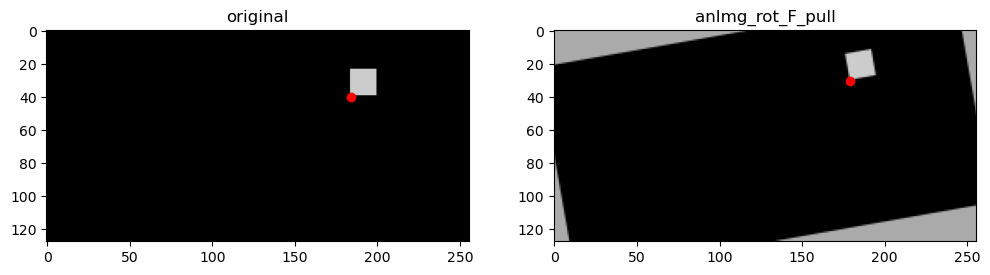

In [24]:
# Apply F.grid_sample() and display resultant image
anImg_batch_channel_added = anImg.unsqueeze(0).unsqueeze(0)
print(f'anImg type {type(anImg)} dtype {anImg.dtype} shape {anImg.shape}')
print(f'anImg_batch_channel_added type {type(anImg_batch_channel_added)} dtype {anImg_batch_channel_added.dtype} shape {anImg_batch_channel_added.shape}')
anImg_batch_channel_added_rot_F_pull = F.grid_sample(
    input=anImg_batch_channel_added, 
    grid=grid_F, 
    mode='bilinear', 
    padding_mode='zeros', 
    align_corners=False)
print(f'anImg_batch_channel_added_rot_F_pull type {type(anImg_batch_channel_added_rot_F_pull)} dtype {anImg_batch_channel_added_rot_F_pull.dtype} shape {anImg_batch_channel_added_rot_F_pull.shape}')
anImg_rot_F_pull = anImg_batch_channel_added_rot_F_pull.squeeze(0).squeeze(0)
print(f'anImg_rot_F_pull type {type(anImg_rot_F_pull)} dtype {anImg_rot_F_pull.dtype} shape {anImg_rot_F_pull.shape}')

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_F_pull, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_F_pull')

In [25]:
# print(f'{pushAffine_np}')
# # array([[  0.8660254,   0.5      , -55.42563  ],
# #        [ -0.5      ,   0.8660254,  49.14875  ],
# #        [  0.       ,   0.       ,   1.       ]], dtype=float32)
# print(f'patch_lower_left_x {patch_lower_left_x} patch_lower_left_y {patch_lower_left_y}')
# #patch_lower_left_x 184 patch_lower_left_y 40
# print(f"cornerPointAfterRot_x {cornerPointAfter30DegCWImageCoord[0]}, cornerPointAfterRot_y {cornerPointAfter30DegCWImageCoord[1]}")
# # cornerPointAfterRot_x 188.49742126464844, cornerPointAfterRot_y 71.21539115905762
# print(f"{(40.-64)/64.0}")
# #-0.375
# print(f"{(71.215-64)/64.0}")
# #0.11273437500000005
# print(f"{(184.-128)/128}")
# #0.4375
# print(f"{(188.497-128)/128}")
# #0.4726328125000001
# print(f"{pushAffine_np @ np.array([patch_lower_left_y,  patch_lower_left_x, 1], 'float32')}")
# # array([ 71.215385, 188.49744 ,   1.      ], dtype=float32)
# print(f"{np.array([[2./toy_h, 0, -1],[0, 2./toy_w, -1 ],[0, 0, 1]],'float32') @  np.array([patch_lower_left_y,  patch_lower_left_x, 1], 'float32')}")
# # array([-0.375 ,  0.4375,  1.    ], dtype=float32)
# print(f"{np.linalg.inv(np.array([[2./toy_h, 0, -1],[0, 2./toy_w, -1 ],[0, 0, 1]],'float32')) @  np.array([-0.375,  0.4375, 1], 'float32')}")
# # array([ 40., 184.,   1.], dtype=float32)
# print(f"{np.array([[2./toy_h, 0, -1],[0, 2./toy_w, -1 ],[0, 0, 1]],'float32') @  np.array([cornerPointAfter30DegCWImageCoord[1],  cornerPointAfter30DegCWImageCoord[0], 1], 'float32')}")
# #array([0.11274052, 0.4726361 , 1.        ], dtype=float32)


In [26]:
# print(f"{normalized_pullAffine_np @ np.array([0.11274049, 0.4726361 , 1.        ], 'float32')}")
# #array([-0.3749999,  0.4375   ,  1.       ], dtype=float32)
# print(f"{normalizeAffineMatImageCoord(pushAffine_np, toy_w, toy_h, toy_w, toy_h) @  np.array([-0.375,  0.4375, 1], 'float32')}")
# #array([0.11274049, 0.4726361 , 1.        ], dtype=float32)

##### Direct conversion from torch-intepol-ij pull grid to  torch-functional-xy pull grid for pull-warping:

The unNormalizedAffineMat (hence the unnormalized Rotation  grid that is used by torch-interpol package) can be pre-multipliecd
to normalize to -1, 1.

Normalization matrix is  np.array([[2./height, 0, -1],[0, 2./width, -1 ],[0, 0, 1]],'float32') .

Further, it seems PyTorch uses 'xy' type meshgrid instead of 'ij' while torch-interpol seems to be using 'ij' type meshgrid.

Hence after normalization of the torch-interpol grid, the  slices are swapped.

In [27]:
def convertPullGrid_interpol2functional_2d(interpol_pull_grid, height, width):
    # print(f'interpol_pull_grid shape {interpol_pull_grid.shape}')
    normalizationMat_lng = torch.from_numpy(np.array([[2./height, 0],[0, 2./width]],'float32'))
    normalizationMat_off = torch.from_numpy(np.array([[-1.,-1.]],'float32'))
    tmp_grid = torch.matmul(normalizationMat_lng, interpol_pull_grid.clone().unsqueeze(-1)) #Before matmul unsqueeze at the end to support batch matmul
    # print(f'tmp_grid shape {tmp_grid.shape}')
    tmp_grid = torch.add(tmp_grid.squeeze(), normalizationMat_off) #Add offset after removing the dimension that was added to support matmul
    # print(f'tmp_grid shape {tmp_grid.shape}')
    tmp_grid = tmp_grid.unsqueeze(0) #Add batch dimension
    # print(f'tmp_grid shape {tmp_grid.shape}')
    #Finally  it we need a 2D 'ij' to 'xy' conversion.
    result_grid = torch.zeros_like(tmp_grid)
    result_grid[...,0]=tmp_grid[...,1]
    result_grid[...,1]=tmp_grid[...,0]
    return result_grid

aTorchFunctionalPullGrid_xy = convertPullGrid_interpol2functional_2d(aRotGrid_pull_explicit, toy_h, toy_w)

# aTorchInterpolPullGrid_ij = aRotGrid_pull_explicit.clone().unsqueeze(0) #add batch
# # The following step is equivalent to  above normalization and 'ij' to 'xy' conversion.
# aTorchFunctionalPullGrid_xy =torch.zeros_like(aTorchInterpolPullGrid_ij)
# aTorchFunctionalPullGrid_xy[:,:,:,1]= torch.add(torch.mul(aTorchInterpolPullGrid_ij[:,:,:,0], float(2.0/toy_h)), -1.0)
# aTorchFunctionalPullGrid_xy[:,:,:,0]= torch.add(torch.mul(aTorchInterpolPullGrid_ij[:,:,:,1], float(2.0/toy_w)), -1.0)

anImg_batch_channel_added_rot_F_pull_convertedGrid type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([1, 1, 128, 256])
anImg_rot_F_pull_convertedGrid type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([128, 256])


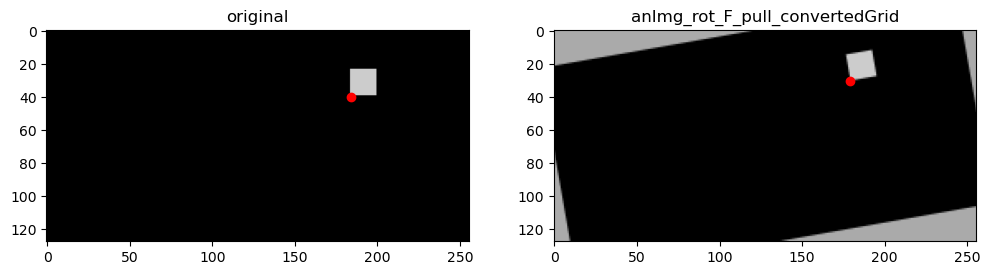

In [28]:
anImg_batch_channel_added_rot_F_pull_convertedGrid = F.grid_sample(
    input=anImg_batch_channel_added, 
    grid=aTorchFunctionalPullGrid_xy, 
    mode='bilinear', 
    padding_mode='zeros', 
    align_corners=False)
print(f'anImg_batch_channel_added_rot_F_pull_convertedGrid type {type(anImg_batch_channel_added_rot_F_pull_convertedGrid)} dtype {anImg_batch_channel_added_rot_F_pull_convertedGrid.dtype} shape {anImg_batch_channel_added_rot_F_pull_convertedGrid.shape}')
anImg_rot_F_pull_convertedGrid = anImg_batch_channel_added_rot_F_pull_convertedGrid.squeeze(0).squeeze(0)
print(f'anImg_rot_F_pull_convertedGrid type {type(anImg_rot_F_pull_convertedGrid)} dtype {anImg_rot_F_pull_convertedGrid.dtype} shape {anImg_rot_F_pull_convertedGrid.shape}')

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_F_pull_convertedGrid, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_F_pull_convertedGrid')

##### Direct conversion  from torch-functional-xy pull grid  to  torch-intepol-ij  grid

To deNormalize, first the slices of torch-functional-xy grid will have to  swapped to make it like ij grid.
Then the grid require multiplication with INVERSE of array([[2./height, 0, -1],[0, 2./width, -1 ],[0, 0, 1]],'float32')

In [29]:

def convertPullGrid_functional2interpol_2d(functional_pull_grid, height, width):
    aResultGrid = torch.zeros_like(functional_pull_grid) 
    #xy to ij
    aResultGrid[...,0] = functional_pull_grid[...,1]
    aResultGrid[...,1] = functional_pull_grid[...,0]
    #Drop the batch dimension
    aResultGrid = aResultGrid.squeeze(0)
    #Add dimension (in-place) in the end to support  matmul
    aResultGrid.unsqueeze_(-1)
    print(f'Step 1: aResultGrid type {type(aResultGrid)} shape {aResultGrid.shape} dtype {aResultGrid.dtype}')
    # torch.Size([128, 256, 2, 1])
    #Compute deNormalizationMat
    deNormalizationMat_np = np.linalg.inv(np.array([[2./height, 0, -1],[0, 2./width, -1 ],[0, 0, 1]],'float32'))
    nb_dim = deNormalizationMat_np.shape[-1] - 1
    deNormalizationMat_rot = torch.from_numpy(deNormalizationMat_np[:nb_dim, :nb_dim])
    deNormalizationMat_tr = torch.from_numpy(deNormalizationMat_np[:nb_dim, -1])
    #Multiply with deNormalization matrix
    aResultGrid = torch.matmul(deNormalizationMat_rot, aResultGrid)
    print(f'Step 2: aResultGrid type {type(aResultGrid)} shape {aResultGrid.shape} dtype {aResultGrid.dtype}')
    #Squeeze the last dimension before adding the translation part
    aResultGrid = aResultGrid.squeeze() + deNormalizationMat_tr
    print(f'Step 3: aResultGrid type {type(aResultGrid)} shape {aResultGrid.shape} dtype {aResultGrid.dtype}')
    return aResultGrid


In [30]:
print(f'aRotGrid_pull_explicit type {type(aRotGrid_pull_explicit)} shape {aRotGrid_pull_explicit.shape} dtype {aRotGrid_pull_explicit.dtype}')
print(f'aTorchFunctionalPullGrid_xy type {type(aTorchFunctionalPullGrid_xy)} shape {aTorchFunctionalPullGrid_xy.shape} dtype {aTorchFunctionalPullGrid_xy.dtype}')
# functional_pull_grid, height, width = aTorchFunctionalPullGrid_xy, toy_h, toy_w
# aResultGrid = convertPullGrid_functional2interpol_2d_v1(functional_pull_grid, height, width)
# aRotGrid_pull_ij_from_torchFuncGrid_xy = aResultGrid
aRotGrid_pull_ij_from_torchFuncGrid_xy = convertPullGrid_functional2interpol_2d(aTorchFunctionalPullGrid_xy, toy_h, toy_w)
print(f'aRotGrid_pull_ij_from_torchFuncGrid_xy type {type(aRotGrid_pull_ij_from_torchFuncGrid_xy)} shape {aRotGrid_pull_ij_from_torchFuncGrid_xy.shape} dtype {aRotGrid_pull_ij_from_torchFuncGrid_xy.dtype}')

aRotGrid_pull_explicit type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32
aTorchFunctionalPullGrid_xy type <class 'torch.Tensor'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32
Step 1: aResultGrid type <class 'torch.Tensor'> shape torch.Size([128, 256, 2, 1]) dtype torch.float32
Step 2: aResultGrid type <class 'torch.Tensor'> shape torch.Size([128, 256, 2, 1]) dtype torch.float32
Step 3: aResultGrid type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32
aRotGrid_pull_ij_from_torchFuncGrid_xy type <class 'torch.Tensor'> shape torch.Size([128, 256, 2]) dtype torch.float32


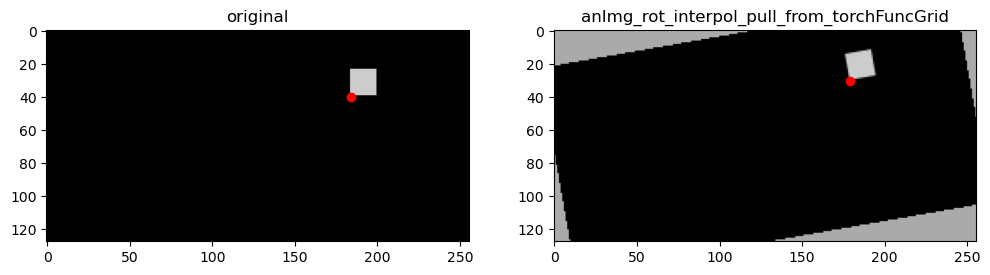

In [31]:
anImg_rot_interpol_pull_from_torchFuncGrid = interpol.grid_pull(anImg, aRotGrid_pull_ij_from_torchFuncGrid_xy, interpolation=1, prefilter=False)

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_rot_interpol_pull_from_torchFuncGrid, cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_rot_interpol_pull_from_torchFuncGrid')

Use VIU DVF class to generate pull type  grid from PyTorch affine matrix theta and apply   DVF warping. Bug fix was needed in the DVF  class to run this successfully.

First create VIU DVF pull type  grid   from   PyTorch affine matrix theta 

In [32]:
# from viu.torch.deformation.fields import DVF
pyTorchThetaForAffineGrid_lastRowRemoved = pyTorchThetaForAffineGrid [0:2, :]
nb_dim = pyTorchThetaForAffineGrid_lastRowRemoved.shape[-1]-1
viuDVFGridSizeParam=(1, 1, toy_h, toy_w, nb_dim)
print(f'pyTorchThetaForAffineGrid_lastRowRemoved type {type(pyTorchThetaForAffineGrid_lastRowRemoved)} shape {pyTorchThetaForAffineGrid_lastRowRemoved.shape} nb_dim {nb_dim}')
print(f'viuDVFGridSizeParam shape: (barch, channel, H, W, nbDim=2): {viuDVFGridSizeParam}')
# print(f'pyTorchThetaForAffineGrid_lastRowRemoved value {pyTorchThetaForAffineGrid_lastRowRemoved}')
#While calling DVF.affine, in the affine matrix, the last row (0,0,1) for 2D or (0,0,0,1) for is removed. However no batch is added.
#Also  while passing the size, the  DVF  dimension  (2 or 3) is being passed  as the last elemet of the size  tuple.
#Further  line #393 of field.py  is to be modified.
#Another important difference  is that  the DVF returned by DVF.affine  includes a subtraction of the identity map
viu_grid_pull = DVF.affine(pyTorchThetaForAffineGrid_lastRowRemoved, size=viuDVFGridSizeParam)
print(f'viu_grid_pull type {type(viu_grid_pull)} shape {viu_grid_pull.shape} dtype {viu_grid_pull.dtype}')

pyTorchThetaForAffineGrid_lastRowRemoved type <class 'torch.Tensor'> shape torch.Size([2, 3]) nb_dim 2
viuDVFGridSizeParam shape: (barch, channel, H, W, nbDim=2): (1, 1, 128, 256, 2)
viu_grid_pull type <class 'viu.torch.deformation.fields.DVF'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32


Verify relation that   viu_grid_pull(affine_mat) = F.affine_grid(affine_mat) - F.affine_grid(identity mat)

In [33]:
pyTorchThetaForAffineGrid_lastRowRemoved = pyTorchThetaForAffineGrid[0:2, :]
print(f'pyTorchThetaForAffineGrid_lastRowRemoved type {type(pyTorchThetaForAffineGrid_lastRowRemoved)} shape {pyTorchThetaForAffineGrid_lastRowRemoved.shape}')
#Create identity matrix as the same shape of pyTorchThetaForAffineGrid_lastRowRemoved
#torch.eye(*aff.shape[-2:], dtype=dtype, device=device)
id_aff_lastRowRemoved = torch.eye(*pyTorchThetaForAffineGrid_lastRowRemoved.shape, dtype=pyTorchThetaForAffineGrid_lastRowRemoved.dtype, device=pyTorchThetaForAffineGrid_lastRowRemoved.device) 
#Add batch
# id_aff = id_aff.expand(n, *id_aff.shape)
id_aff_lastRowRemoved_batchAdded = id_aff_lastRowRemoved.unsqueeze(0)
print(f'id_aff_lastRowRemoved_batchAdded type {type(id_aff_lastRowRemoved_batchAdded)} shape {id_aff_lastRowRemoved_batchAdded.shape}')
# _id = F.affine_grid(id_aff,  size[:-1], align_corners=align_corners)
_id = F.affine_grid(
    id_aff_lastRowRemoved_batchAdded,
    torch.Size([1, 1, toy_h, toy_w]),
    align_corners=align_corners)
print(f'_id type {type(_id)} shape {_id.shape} dtype {_id.dtype}')
print(f'Computed earlier: grid_F type {type(grid_F)} shape {grid_F.shape} dtype {grid_F.dtype}')
tmp_viu_grid_pull = grid_F - _id
print(f'tmp_viu_grid_pull type {type(tmp_viu_grid_pull)} shape {tmp_viu_grid_pull.shape} dtype {tmp_viu_grid_pull.dtype}')
#print maximum difference:
print(f'Maximum difference with viu_grid_pull: {torch.max(torch.abs(viu_grid_pull - tmp_viu_grid_pull))}')

pyTorchThetaForAffineGrid_lastRowRemoved type <class 'torch.Tensor'> shape torch.Size([2, 3])
id_aff_lastRowRemoved_batchAdded type <class 'torch.Tensor'> shape torch.Size([1, 2, 3])
_id type <class 'torch.Tensor'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32
Computed earlier: grid_F type <class 'torch.Tensor'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32
tmp_viu_grid_pull type <class 'torch.Tensor'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32
Maximum difference with viu_grid_pull: DVF(0.0015)


Apply VIU DVF (pull) warping

viu_grid_pull type <class 'viu.torch.deformation.fields.DVF'> shape torch.Size([1, 128, 256, 2]) dtype torch.float32
anImg_batch_channel_added type <class 'torch.Tensor'> dtype torch.float32 shape torch.Size([1, 1, 128, 256])


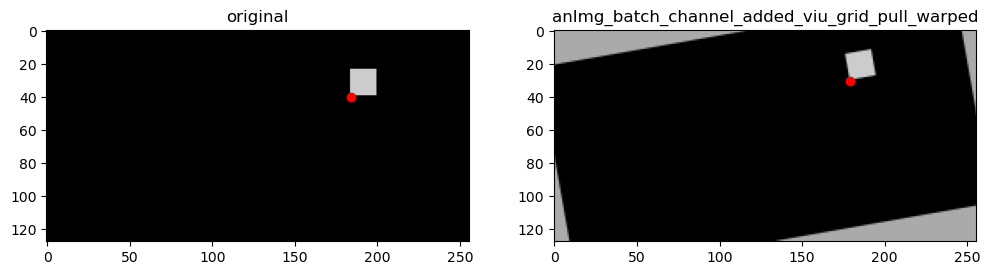

In [35]:
print(f'viu_grid_pull type {type(viu_grid_pull)} shape {viu_grid_pull.shape} dtype {viu_grid_pull.dtype}')
print(f'anImg_batch_channel_added type {type(anImg_batch_channel_added)} dtype {anImg_batch_channel_added.dtype} shape {anImg_batch_channel_added.shape}')

anImg_batch_channel_added_viu_grid_pull_warped = viu_grid_pull(
    anImg_batch_channel_added,
    mode='bilinear', 
    padding_mode='zeros')

fig, axArray = plt.subplots(1,2, figsize=(12, 6))
axArray[0].imshow(anImg,     cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[0].title.set_text('original')
axArray[0].plot(patch_lower_left_x, patch_lower_left_y, "o", color="r")
axArray[1].imshow(anImg_batch_channel_added_viu_grid_pull_warped.squeeze(0).squeeze(0), cmap=reg_cmap, vmin=reg_vmin, vmax=reg_vmax)
axArray[1].plot(cornerPointAfter30DegCWImageCoord[0], cornerPointAfter30DegCWImageCoord[1], "o", color="r")
axArray[1].title.set_text('anImg_batch_channel_added_viu_grid_pull_warped')